<a href="https://colab.research.google.com/github/droxide16/classificaton/blob/main/test_transfer_learning1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Ganti path di bawah sesuai lokasi dataset kamu di Google Drive
# Struktur folder harus seperti ini:
# drive/MyDrive/dataset_daun/
# ├── Daun Nangka/
# └── Daun Sirih/
dataset_path = '/content/drive/MyDrive/dataset'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)


Found 82 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [4]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(2, activation='softmax')(x)  # dua kelas

model = Model(inputs=base_model.input, outputs=predictions)

# Bekukan layer base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [6]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator
)


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4668 - loss: 0.7062 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5906 - loss: 0.6793 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5441 - loss: 0.7154 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5687 - loss: 0.6983 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5723 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5432 - loss: 0.6840 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4402 - loss: 0.7400 - val_accuracy: 0.5000 - val_loss: 0.6928
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4949 - loss: 0.6997 - val_accuracy: 0.5000 - val_loss: 0.6929
E

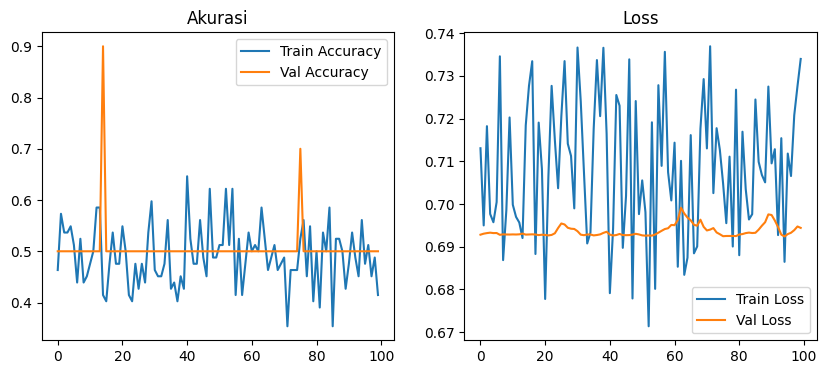

In [7]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Akurasi')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


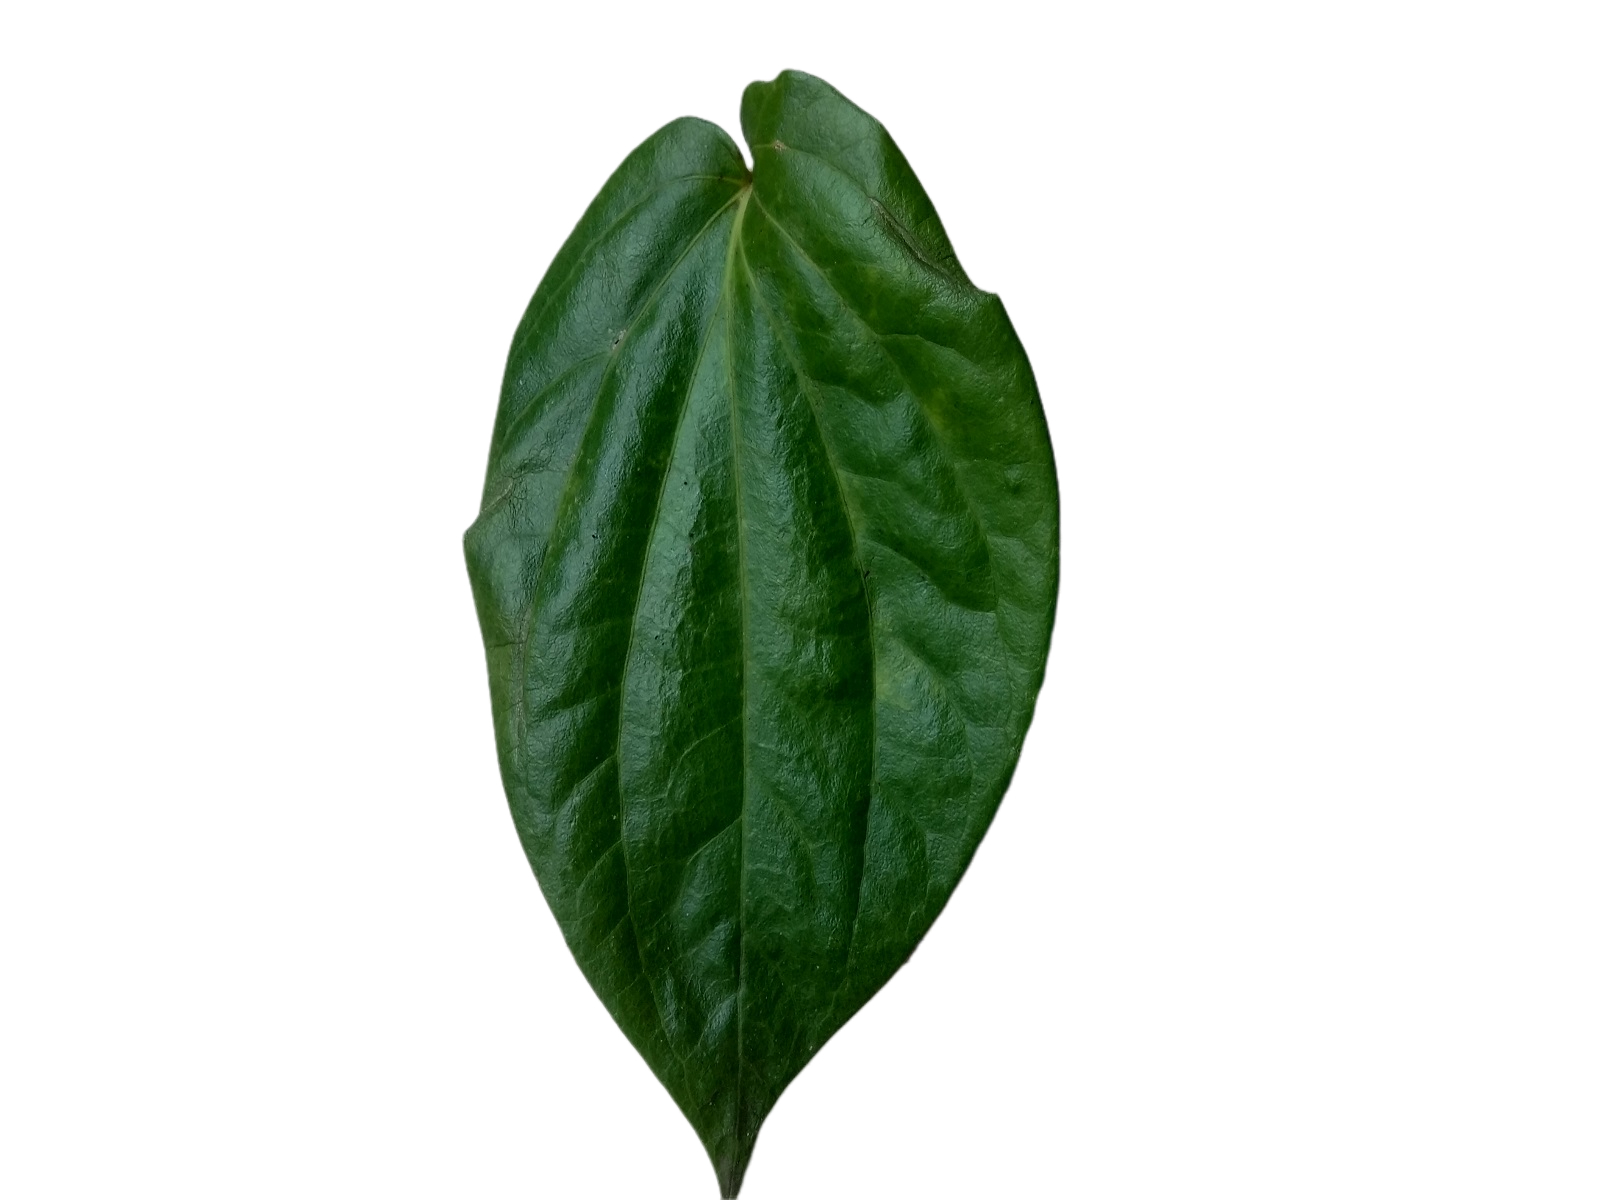

Prediksi: Daun Sirih (53.27%)


In [14]:
from google.colab.patches import cv2_imshow  # untuk menampilkan gambar di Colab

# Ganti path gambar yang mau diuji
test_image_path = dataset_path + '/Daun Sirih/019.jpg'

# Load dan preprocess
img = tf.keras.preprocessing.image.load_img(test_image_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Prediksi
pred = model.predict(img_array)
class_labels = list(train_generator.class_indices.keys())

predicted_class = class_labels[np.argmax(pred)]
confidence = np.max(pred) * 100

# Tampilkan hasil
img_bgr = cv2.imread(test_image_path)
cv2_imshow(img_bgr)
print(f"Prediksi: {predicted_class} ({confidence:.2f}%)")


In [15]:
model.save('/content/drive/MyDrive/model_daun_effnet.h5')
print("Model telah disimpan ke Google Drive!")


Model telah disimpan ke Google Drive!


In [16]:
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)


Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.4345 - loss: 0.7141 - val_accuracy: 0.5000 - val_loss: 0.6945
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5097 - loss: 0.7317 - val_accuracy: 0.5000 - val_loss: 0.6943
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4975 - loss: 0.7209 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.4741 - loss: 0.7290 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5627 - loss: 0.7418 - val_accuracy: 0.5000 - val_loss: 0.6937


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi semua batch validasi
val_generator.reset()
pred = model.predict(val_generator)
y_pred = np.argmax(pred, axis=1)
y_true = val_generator.classes

class_labels = list(val_generator.class_indices.keys())


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step


In [20]:
report = classification_report(y_true, y_pred, target_names=class_labels)
print("=== Classification Report ===")
print(report)


=== Classification Report ===
              precision    recall  f1-score   support

 Daun Nangka       0.00      0.00      0.00        10
  Daun Sirih       0.50      1.00      0.67        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


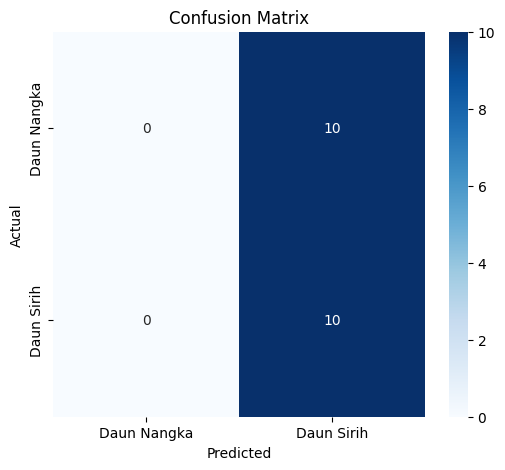

In [21]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [22]:
from sklearn.metrics import precision_recall_fscore_support

# Hitung precision, recall, f1 untuk tiap kelas
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, labels=np.unique(y_true)
)

# Gabungkan ke dictionary
metrics_data = {
    'Kelas': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

import pandas as pd
df_metrics = pd.DataFrame(metrics_data)
df_metrics


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Kelas,Precision,Recall,F1-Score
0,Daun Nangka,0.0,0.0,0.000000
1,Daun Sirih,0.5,1.0,0.666667


from matplotlib import pyplot as plt
df_metrics['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['F1-Score'].plot(kind='hist', bins=20, title='F1-Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_metrics.groupby('Kelas').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics.plot(kind='scatter', x='Recall', y='F1-Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Precision']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Precision'}, axis=1)
              .sort_values('Precision', ascending=True))
  xs = counted['Precision']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_metrics.sort_values('Precision', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Kelas')):
  _plot_series(series, series_name, i)
  fig.legend(title='Kelas', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Precision')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Recall']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Recall'}, axis=1)
              .sort_values('Recall', ascending=True))
  xs = counted['Recall']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_metrics.sort_values('Recall', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Kelas')):
  _plot_series(series, series_name, i)
  fig.legend(title='Kelas', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Recall')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['F1-Score']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'F1-Score'}, axis=1)
              .sort_values('F1-Score', ascending=True))
  xs = counted['F1-Score']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_metrics.sort_values('F1-Score', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Kelas')):
  _plot_series(series, series_name, i)
  fig.legend(title='Kelas', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('F1-Score')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
df_metrics['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['F1-Score'].plot(kind='line', figsize=(8, 4), title='F1-Score')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_metrics['Kelas'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_metrics, x='Precision', y='Kelas', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_metrics['Kelas'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_metrics, x='Recall', y='Kelas', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_metrics['Kelas'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_metrics, x='F1-Score', y='Kelas', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

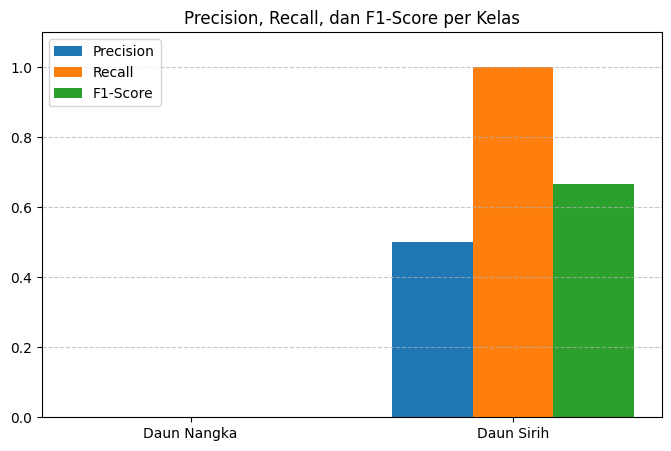

In [23]:
plt.figure(figsize=(8, 5))
x = np.arange(len(class_labels))
width = 0.25

plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-Score')

plt.xticks(x, class_labels)
plt.ylim(0, 1.1)
plt.title('Precision, Recall, dan F1-Score per Kelas')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


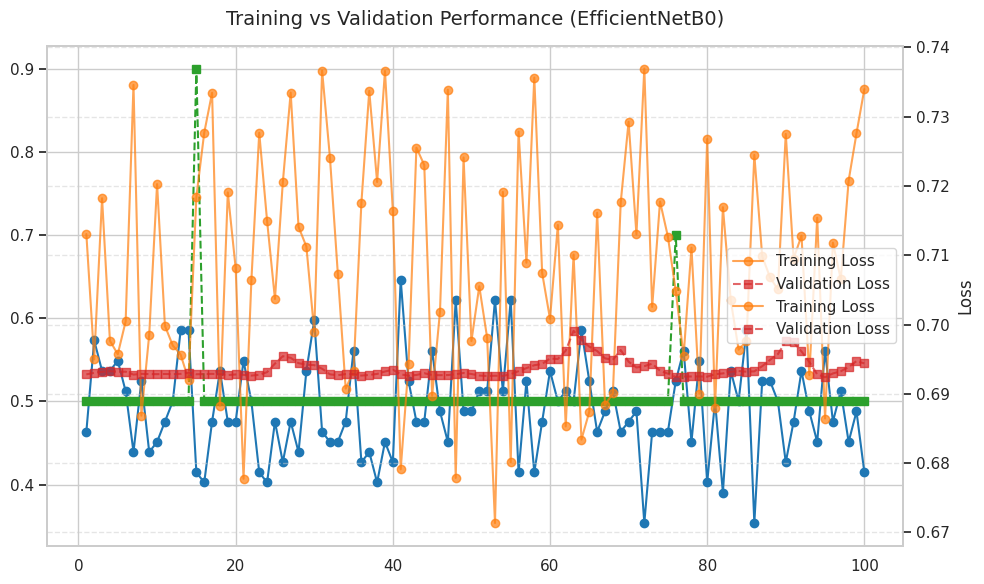

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gunakan style yang lebih elegan
sns.set(style="whitegrid")

# Ambil data akurasi & loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Ukuran figure
plt.figure(figsize=(10, 6))

# Plot Akurasi
plt.plot(epochs, acc, 'o-', label='Training Accuracy', color='tab:blue')
plt.plot(epochs, val_acc, 's--', label='Validation Accuracy', color='tab:green')

# Buat sumbu kedua untuk loss
ax2 = plt.gca().twinx()
ax2.plot(epochs, loss, 'o-', label='Training Loss', color='tab:orange', alpha=0.7)
ax2.plot(epochs, val_loss, 's--', label='Validation Loss', color='tab:red', alpha=0.7)

# Label dan judul
plt.title('Training vs Validation Performance (EfficientNetB0)', fontsize=14, pad=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)

# Gabungkan legend dari kedua sumbu
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc='center right', frameon=True)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
